In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)


Extracting ./cifar-10-python.tar.gz to ./


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

In [5]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [6]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [15]:
def fit(epoch, model, trainloader, testloader, optimizer,scheduler,name='model', random_shuffle=False, shuffled_pixels=False):
  history_t = []
  history_v = []
  history_loss = []
  step_count = 0
  criterion = nn.CrossEntropyLoss().to(device)
  if shuffled_pixels:
    rng = np.random.default_rng()
  for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      if random_shuffle:
        labels = labels[torch.randperm(len(labels))]
      if shuffled_pixels:
        data_ = data.cpu().numpy()
        data_perm = rng.permutation(data_, axis=2)
        data = torch.from_numpy(data_perm)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      step_count += 1
      if step_count%1000==0:
        acc_t,acc_v = eval_model(model,trainloader,testloader)
        model.train()
        history_t.append(acc_t)
        history_v.append(acc_v)
        log_ = str(step_count)+","+str(acc_t)+","+str(acc_v)+ "," + str(running_loss/1000)+"\n"
        with open("{}.log".format(name), "a") as f:
          f.write(log_)
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss/1000,acc_t, acc_v))
    history_loss.append(running_loss/1000)
    scheduler.step()
  return model,history_t,history_v, history_loss

In [11]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss = fit(100, net, trainloader, testloader, optimizer,scheduler, name='normal_labels')

Epoch 1 | loss: 3.8118 | Train acc: 0.1019 | Val acc: 0.1009
Epoch 2 | loss: 3.6089 | Train acc: 0.1005 | Val acc: 0.1004
Epoch 3 | loss: 3.6095 | Train acc: 0.1010 | Val acc: 0.1004
Epoch 4 | loss: 3.6075 | Train acc: 0.1003 | Val acc: 0.1001
Epoch 5 | loss: 3.6082 | Train acc: 0.1008 | Val acc: 0.1003
Epoch 6 | loss: 3.6079 | Train acc: 0.1002 | Val acc: 0.1002
Epoch 7 | loss: 3.6070 | Train acc: 0.1006 | Val acc: 0.1003
Epoch 8 | loss: 3.6066 | Train acc: 0.1005 | Val acc: 0.1003
Epoch 9 | loss: 3.6064 | Train acc: 0.0986 | Val acc: 0.0990
Epoch 10 | loss: 3.6058 | Train acc: 0.1009 | Val acc: 0.1005
Epoch 11 | loss: 3.5749 | Train acc: 0.1204 | Val acc: 0.1213
Epoch 12 | loss: 3.5544 | Train acc: 0.1209 | Val acc: 0.1195
Epoch 13 | loss: 3.1537 | Train acc: 0.2693 | Val acc: 0.2670
Epoch 14 | loss: 2.7399 | Train acc: 0.3557 | Val acc: 0.3550
Epoch 15 | loss: 2.5227 | Train acc: 0.4229 | Val acc: 0.4125
Epoch 16 | loss: 2.3317 | Train acc: 0.4671 | Val acc: 0.4617
Epoch 17 | loss: 

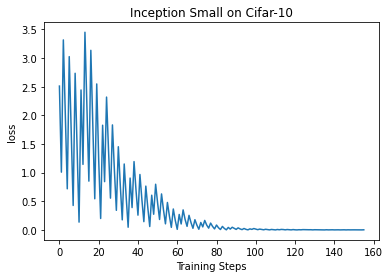

In [12]:
plt.plot(list(history_loss), label='true labels')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()

In [ ]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss_random = fit(100, net, trainloader, testloader, optimizer,scheduler, name='random_labels', random_shuffle=True)

Epoch 1 | loss: 3.9750 | Train acc: 0.1000 | Val acc: 0.1002


In [ ]:
plt.plot(list(history_loss_random), label='random labels')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()

In [ ]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss_shuffled_pixels = fit(100, net, trainloader, testloader, optimizer,scheduler, name='shuffled_pixels', shuffled_pixels=True)

In [ ]:
plt.plot(list(history_loss_shuffled_pixels), label='shuffled pixels')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()